<a href="https://colab.research.google.com/github/GodJiLee/Dacon/blob/main/%EA%B5%AC%EB%82%B4%EC%8B%9D%EB%8B%B9%20%EC%8B%9D%EC%88%98%EC%9D%B8%EC%9B%90%20%EC%98%88%EC%B8%A1/86_4420269999_%EC%95%99%EC%83%81%EB%B8%94_%EA%B5%AC%EB%82%B4%EC%8B%9D%EB%8B%B9.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **드라이브 마운트**

# **필요 모듈 설치 및 Import**

In [ ]:
!pip install catboost
!pip install pycaret
from tqdm.notebook import tqdm
import pandas as pd
import numpy as np
import datetime as dt
from pycaret.regression import *

     |████████████████████████████████| 69.2MB 41kB/s 
     |████████████████████████████████| 266kB 4.1MB/s 
     |████████████████████████████████| 14.2MB 216kB/s 
     |████████████████████████████████| 112kB 44.2MB/s 
     |████████████████████████████████| 1.4MB 36.4MB/s 
     |████████████████████████████████| 61kB 6.0MB/s 
     |████████████████████████████████| 6.8MB 21.8MB/s 
     |████████████████████████████████| 276kB 36.8MB/s 
     |████████████████████████████████| 174kB 38.3MB/s 
     |████████████████████████████████| 2.0MB 32.9MB/s 
     |████████████████████████████████| 1.7MB 37.9MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 81kB 8.9MB/s 
     |████████████████████████████████| 256kB 36.3MB/s 
     |████████████████████████████████| 1.1MB 35.7MB/s 
     |████████████████████████████████| 645kB 34.2MB/

# **데이터 로드 및 피쳐 생성**

In [ ]:
train = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/dacon_contest1/data/train.csv')
test = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/dacon_contest1/data/test.csv')

In [ ]:
# 정수형으로 타입 변경
train[['현본사소속재택근무자수', '중식계', '석식계']] = train[['현본사소속재택근무자수', '중식계', '석식계']].astype('int')
test['현본사소속재택근무자수'] = test['현본사소속재택근무자수'].astype('int')

print('done')

In [ ]:
# datetime으로 변경
train['일자'] = pd.to_datetime(train['일자'])
test['일자'] = pd.to_datetime(test['일자'])

print('done')

In [ ]:
# datetime 쪼개기
train['년'] = train['일자'].dt.year
train['월'] = train['일자'].dt.month
train['일'] = train['일자'].dt.day
train['주'] = train['일자'].dt.week
train['요일'] = train['일자'].dt.weekday

print('done')

In [ ]:
# 데이터 간 연산으로 새로운 column 생성
train['출근'] = train['본사정원수'] - (train['본사휴가자수'] + train['본사출장자수'] + train['현본사소속재택근무자수'])
train['휴가비율'] = train['본사휴가자수'] / train['본사정원수']
train['출장비율'] = train['본사출장자수'] / train['본사정원수']
train['야근비율'] = train['본사시간외근무명령서승인건수'] / train['출근']
train['재택비율'] = train['현본사소속재택근무자수'] / train['본사정원수']

print('done')

In [ ]:
# test dataset에 대해서도 똑같이 처리
test['년'] = test['일자'].dt.year
test['월'] = test['일자'].dt.month
test['일'] = test['일자'].dt.day
test['주'] = test['일자'].dt.week
test['요일'] = test['일자'].dt.weekday

print('done')

In [ ]:
# test dataset에 대해서도 똑같이 처리
test['출근'] = test['본사정원수'] - (test['본사휴가자수'] + test['본사출장자수'] + test['현본사소속재택근무자수'])
test['휴가비율'] = test['본사휴가자수'] / test['본사정원수'] 
test['출장비율'] = test['본사출장자수'] / test['본사정원수'] 
test['야근비율'] = test['본사시간외근무명령서승인건수'] / test['출근']
test['재택비율'] = test['현본사소속재택근무자수'] / test['본사정원수']

print('done')

# **변수 간 관계 시각화**

**일-석식계 간 관계**

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize = (12, 6))
sns.boxplot(train['일'], train['석식계'])

**주-석식계 간 관계**

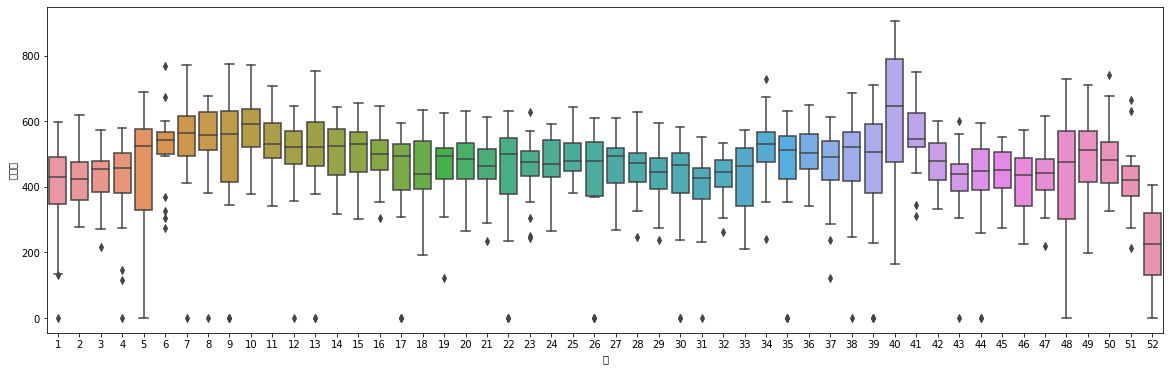

In [ ]:
plt.figure(figsize = (20, 6))
sns.boxplot(train['주'], train['석식계'])

**월-석식계 간 관계**

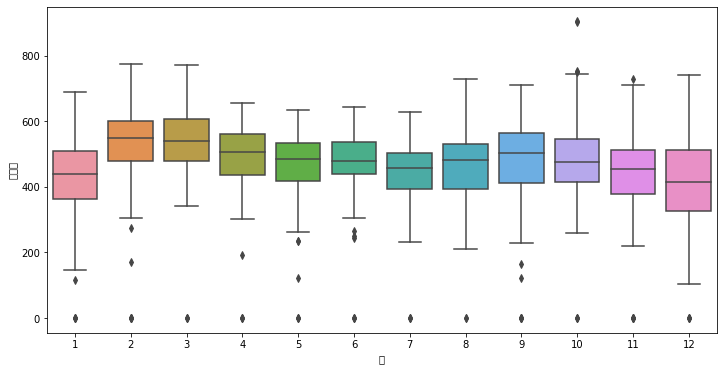

In [ ]:
plt.figure(figsize = (12, 6))
sns.boxplot(train['월'], train['석식계'])

**년도-석식계 간 관계**

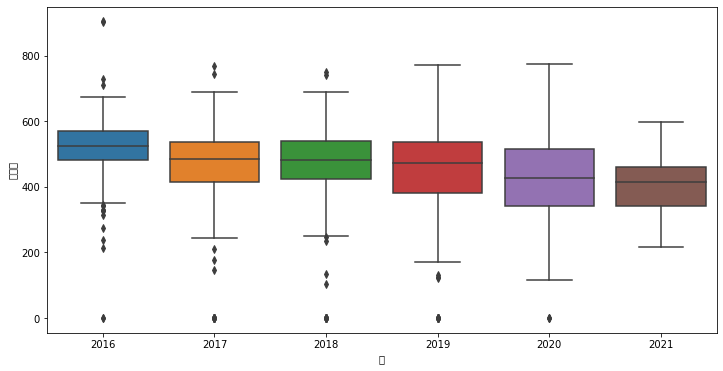

In [ ]:
plt.figure(figsize = (12, 6))
sns.boxplot(train['년'], train['석식계'])

**야근인원수-석식계 간 관계**   
본사시간외근무명령서승인건수=**야근**

<Figure size 864x432 with 0 Axes>

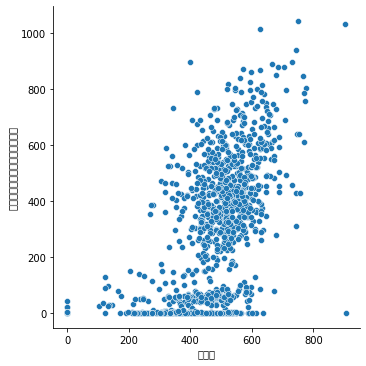

In [ ]:
plt.figure(figsize=(12,6))
sns.relplot(train['석식계'], train['본사시간외근무명령서승인건수'])

# **NLP**

- 메뉴의 종류를 원-핫 인코딩으로 분류시켜 학습하니 성능 상승
- '주' 및 '월' 데이터를 추가해서 연초 연말 월초 월말 알아서 학습하도록 유도

**메뉴 임베딩**

In [ ]:
# 중식메뉴, 석식메뉴 split
def get_food_embedding(x):
    x_ = []
    x = x.split(' ')
    for i in x:
        if '(' in i and ')' in i:
            continue
        if '/' in i:
            x_.extend(i.split('/')) # 리스트 내 값을 풀어서 할당
        else:
            x_.append(i) # 값 그대로 할당
    
    x_ = list(set(x_)) # 중복 제거 후 다시 리스트로
    x_.remove('') # 비어있는 값 제거
    return x_

train['중식메뉴_split'] = train['중식메뉴'].apply(lambda x: get_food_embedding(x))
train['석식메뉴_split'] = train['석식메뉴'].apply(lambda x: get_food_embedding(x))    

In [ ]:
train.head()

,일자,요일,본사정원수,본사휴가자수,본사출장자수,본사시간외근무명령서승인건수,현본사소속재택근무자수,조식메뉴,중식메뉴,석식메뉴,중식계,석식계,년,월,일,주,출근,휴가비율,출장비율,야근비율,재택비율,중식메뉴_split,석식메뉴_split
0,2016-02-01,0,2601,50,150,238,0,모닝롤/찐빵 우유/두유/주스 계란후라이 호두죽/쌀밥 (쌀:국내산) 된장찌개 쥐...,"쌀밥/잡곡밥 (쌀,현미흑미:국내산) 오징어찌개 쇠불고기 (쇠고기:호주산) 계란찜 ...","쌀밥/잡곡밥 (쌀,현미흑미:국내산) 육개장 자반고등어구이 두부조림 건파래무침 ...",1039,331,2016,2,1,5,2401,0.019223,0.057670,0.099125,0.0,"[쇠불고기, 오징어찌개, 쌀밥, 포기김치, 청포묵무침, 잡곡밥, 계란찜, 요구르트]","[육개장, 건파래무침, 두부조림, 쌀밥, 포기김치, 잡곡밥, 자반고등어구이]"
1,2016-02-02,1,2601,50,173,319,0,모닝롤/단호박샌드 우유/두유/주스 계란후라이 팥죽/쌀밥 (쌀:국내산) 호박젓국찌...,"쌀밥/잡곡밥 (쌀,현미흑미:국내산) 김치찌개 가자미튀김 모둠소세지구이 마늘쫑무...","콩나물밥*양념장 (쌀,현미흑미:국내산) 어묵국 유산슬 (쇠고기:호주산) 아삭고추무...",867,560,2016,2,2,5,2378,0.019223,0.066513,0.134146,0.0,"[김치찌개, 쌀밥, 가자미튀김, 모둠소세지구이, 마늘쫑무침, 배추겉절이, 잡곡밥, ...","[콩나물밥*양념장, 포기김치, 바나나, 아삭고추무침, 어묵국, 유산슬]"
2,2016-02-03,2,2601,56,180,111,0,모닝롤/베이글 우유/두유/주스 계란후라이 표고버섯죽/쌀밥 (쌀:국내산) 콩나물국...,"카레덮밥 (쌀,현미흑미:국내산) 팽이장국 치킨핑거 (닭고기:국내산) 쫄면야채무침 ...","쌀밥/잡곡밥 (쌀,현미흑미:국내산) 청국장찌개 황태양념구이 (황태:러시아산) 고기...",1017,573,2016,2,3,5,2365,0.021530,0.069204,0.046934,0.0,"[카레덮밥, 팽이장국, 치킨핑거, 포기김치, 쫄면야채무침, 견과류조림, 요구르트]","[쌀밥, 청국장찌개, 황태양념구이, 포기김치, 새송이버섯볶음, 잡곡밥, 고기전]"
3,2016-02-04,3,2601,104,220,355,0,"모닝롤/토마토샌드 우유/두유/주스 계란후라이 닭죽/쌀밥 (쌀,닭:국내산) 근대국...","쌀밥/잡곡밥 (쌀,현미흑미:국내산) 쇠고기무국 주꾸미볶음 부추전 시금치나물 ...","미니김밥*겨자장 (쌀,현미흑미:국내산) 우동 멕시칸샐러드 군고구마 무피클 포...",978,525,2016,2,4,5,2277,0.039985,0.084583,0.155907,0.0,"[주꾸미볶음, 쌀밥, 포기김치, 쇠고기무국, 시금치나물, 잡곡밥, 부추전, 요구르트]","[무피클, 우동, 포기김치, 군고구마, 멕시칸샐러드, 미니김밥*겨자장]"
4,2016-02-05,4,2601,278,181,34,0,모닝롤/와플 우유/두유/주스 계란후라이 쇠고기죽/쌀밥 (쌀:국내산) 재첩국 방...,"쌀밥/잡곡밥 (쌀,현미흑미:국내산) 떡국 돈육씨앗강정 (돼지고기:국내산) 우엉잡채...","쌀밥/잡곡밥 (쌀,현미흑미:국내산) 차돌박이찌개 (쇠고기:호주산) 닭갈비 (닭고기:...",925,330,2016,2,5,5,2142,0.106882,0.069589,0.015873,0.0,"[돈육씨앗강정, 쌀밥, 포기김치, 우엉잡채, 청경채무침, 떡국, 잡곡밥, 요구르트]","[차돌박이찌개, 감자소세지볶음, 쌀밥, 닭갈비, 포기김치, 콩나물무침, 잡곡밥]"


In [ ]:
# test set에도 동일하게 적용
test['중식메뉴_split'] = test['중식메뉴'].apply(lambda x: get_food_embedding(x))
test['석식메뉴_split'] = test['석식메뉴'].apply(lambda x: get_food_embedding(x))

In [ ]:
train['중식메뉴_split'][0]

['쇠불고기', '오징어찌개', '쌀밥', '포기김치', '청포묵무침', '잡곡밥', '계란찜', '요구르트']

In [ ]:
# 중식계
lunch_lst = []
lunch_count = []
pref = 0
for i in tqdm(range(1205)): # 진행상황 반환 (1205는 train set 데이터 개수)
    try:
        if train['중식계'][i] >= 880: # 880은 중식계 평균값
            pref = 1
        else:
            pref = 0
        
        lunch_lst.append(train['중식메뉴_split'][i])
        lunch_count.append(pref)

    except:
        pass

# for i in range(len(lunch_lst)):
    # lunch_lst[i] = lunch_lst[i].replace(',', ' ')

print('done')


done


In [ ]:
is_comma = 0

for j in range(len(dinner_lst_test)):
    for i in range(len(dinner_lst_test[j])):
        if ',' not in dinner_lst_test[i]:
            is_comma += 0
        else:
            is_comma += 1

NameError: ignored

In [ ]:
is_comma

In [ ]:
# 석식계에 대해서도 마찬가지로 처리
dinner_lst = []
dinner_count = []
pref_d = 0
for i in tqdm(range(1205)):
    try:
        if train['석식계'][i] > 476:
            pref_d = 1
        else:
            pref_d = 0
        
        dinner_lst.append(train['석식메뉴_split'][i])
        dinner_count.append(pref_d)
    except:
        pass

# for i in range(len(dinner_lst)):
    # dinner_lst[i] = dinner_lst[i].replace(',', ' ')
print('done')

In [ ]:
#test set에 대해서도 같은 작업
lunch_lst_test = []
lunch_count_test = []
for i in tqdm(range(50)):
    try:
        lunch_lst_test.append(test['중식메뉴_split'][i])
        lunch_count_test.append(0)
    except:
        pass

# for i in range(len(lunch_lst_test)):
    # lunch_lst_test[i] = lunch_lst_test[i].replace(',', ' ')

print('done')

In [ ]:
# test set에 대해서도 같은 작업
dinner_lst_test = []
dinner_count_test = []
for i in tqdm(range(50)):
    try:
        dinner_lst_test.append(test['석식메뉴_split'][i])
        dinner_count_test.append(0)
    except:
        pass

# for i in range(len(dinner_lst_test)):
    # dinner_lst_test[i] = dinner_lst_test[i].replace(',', ' ')

print('done')

In [ ]:
# 데이터프레임화
lunch_df = pd.DataFrame({'중식메뉴':lunch_lst})
dinner_df = pd.DataFrame({'석식메뉴':dinner_lst})
lunch_df_t = pd.DataFrame({'중식메뉴':lunch_lst_test})
dinner_df_t = pd.DataFrame({'석식메뉴':dinner_lst_test})

In [ ]:
lunch_df

# **모든 메뉴의 분류**

In [ ]:
# 메뉴리스트 만들기
# menu = pd.read_csv('', encoding = 'cp949') # cp949는 EUC-KR 개선 버전

In [ ]:
lunch_df.iloc[1][0][1]

'쌀밥'

In [ ]:
food = list(menu['메뉴'])
result_lunch = []
result_dinner = []

for k in range(len(lunch_df)):
    trigger = np.zero(34, dtype = 'int') # 빈 배열 trigger에 할당

    for i in range(len(lunch_df.iloc[k][0])): # 행번호 기준 데이터 읽기 
        if lunch_df.iloc[k][0][i] in food:
            trigger += np.array(menu[menu['메뉴'] == lunch_df.iloc[k][0][i]].iloc[0][1:-1], dtype = 'int')
    trigger = trigger / trigger.sum()
    result_lunch.append(trigger)

NameError: ignored

In [ ]:
# 석식계에 대해서도 동일하게 적용
for k in range(len(dinner_df)):
    trigger = np.zeros(34, dtype = 'int')

    for i in range(len(dinner_df.iloc[k][0])):
        if dinner_df.iloc[k][0][i] in food:
            trigger += np.array(menu[menu['메뉴'] == dinner_df.iloc[k][0][i].iloc[0][1:-1], dtype = 'int')
    
    trigger = trigger / trigger.sum()
    result_dinner.append(tigger)

In [ ]:
# test set에 대해서도 동일하게 적용
result_lunch_t = []
result_dinner_t = []

for k in range(len(lunch_df_t)):
    trigger = np.zeros(34, dtype = 'int')
    for i in range(len(lunch_df_t.iloc[k][0])):
        if lunch_df_t.iloc[k][0][i] in food:
            trigger += np.array(menu[menu['메뉴'] == lunch_df_t.iloc[k][0][i]].iloc[0][1:-1], dtype = 'int')
    trigger = trigger / trigger.sum()
    result_lunch_t.append(trigger

In [ ]:
# test set에 대해서도 동일하게 적용
for k in range(len(dinner_df_t)):
    trigger = np.zeros(34, dtype = 'int')
    for i in range(len(dinner_df_t.iloc[k][0])):
        if dinner_df_t.iloc[k][0][i] in food:
            trigger += np.array(menu[menu['메뉴'] == dinner_df_t.iloc[k][0][i]].iloc[0][1:-1], dtype = 'int')
            
    trigger = trigger / trigger.sum()
    result_dinner_t.append(trigger)

NameError: ignored

**메뉴 데이터 생성**

In [ ]:
column = list(menu.column[1:-1])
lunch_sort = pd.DataFrame(result_lunch, columns = column)
dinner_sort = pd.DataFrame(result_dinner, columns = column)
lunch_sort_t = pd.DataFrame(result_lunch_t, columns = column)
dinner_sort_t = pd.DataFrame(result_dinner_t, columns = column)

# **- Feature Engineering**

**문화의 날**
* 매달 마지막 주 수요일 문화의 날 지정
* 석식 0명인 Feature 발견
* 따로 지정하지 않아도 일, 주 데이터로 학습이 됨

In [ ]:
train = train[train['석식계'] != 0]

In [ ]:
train['문화의날'] = 0
test['문화의날'] = 0

In [ ]:
# 매달 마지막 주 수요일 문화의 날 지정
a = train[(train['일'] > 25) & (train['요일'] == 2)].index
a = list(a)

In [ ]:
# test set에 대해서도 마찬가지로 지정
b = test[(test['일'] > 25) & (test['요일'] == 2)].index
b = list(b)

In [ ]:
# 데이터셋에 문화의날 반영
train['문화의날'][a] = 1
test['문화의날'][b] = 1

**강수량 및 기온 Feature Generating**
* 외부 데이터(기상청) 사용
* 기온 및 강수량에 따라 중식계 영향을 미칠 것으로 예상
* 본거지가 진주가 아닌 사원들이 많아 기숙사 생활 인원이 많음
* 따라서 강수량 및 기온은 크게 영향을 미치지 않을 것으로 추정

In [ ]:
# 기상청 강수량, 기온 데이터 불러오기
rain_2016 = pd.read_csv('')
rain_2017 = pd.read_csv('')
rain_2018 = pd.read_csv('')
rain_2019 = pd.read_csv('')
rain_2020 = pd.read_csv('')
rain_2021 = pd.read_csv('')

tem_2016 = pd.read_csv('')
tem_2017 = pd.read_csv('')
tem_2018 = pd.read_csv('')
tem_2019 = pd.read_csv('')
tem_2020 = pd.read_csv('')
tem_2021 = pd.read_csv('')

FileNotFoundError: ignored

In [ ]:
def rain_chart_maker(df, n):
    key = {}
    lst_rain = []

    c = df[(df['hour'] == 1100) * (df[df.columns[2]] > 5)] # maybe 주말, 퇴근후?
    for i in range(len(c.index)): # index = 위치 찾는 함수
        mother_r = str(int((c.index[i] // 24) / 30) + 2)

        try:
            day_r = df[' format: day'][c.index[i]].lstrip() # lstrip() 함수는 인자로 전달된 문자를 왼쪽부터 제거

        except:
            pass

        year = str(n)

        try:
            if (int((c.index[i] // 24) / 30) + 2) < 10 and (int(df[' format: day'][c.index[i]]) < 10):
                key[pd.to_datetime(year + '-0' + month_r + '-0' + day_r)] = df[df.columns[2]][c.index[i]]
                lst_rain.append(pd.to_datetime(year + '-0' + month_r + '-0' + day_r))
                # key.append({year + '-0' + month_r + '-0' + day_r : df[df.columns[2]][c.index[i]]})

            if (int((c.index[i] // 24) / 30) + 2) >= 10 and (int(df[' format: day'][c.index[i]]) < 10):
                key[pd.to_datetime(year + '-' + month_r + '-0' + day_r)] = df[df.columns[2]][c.index[i]]
                lst_rain.append(pd.to_datetime(year + '-' + month_r + '-0' + day_r))
                # key.append({year + '-' + month_r + '-0' + day_r : df[df.columns[2]][c.index[i]]]})
            
            if(int((c.index[i] // 24) / 30) + 2) < 10 and (int(df[' format: day'][c.index[i]]) >= 10):
                key[pd.to_datetime(year + '-0' + month_r + '-' + day_r)] = df[df.columns[2]][c.index[i]]
                lst_rain.append(pd.to_datetime(year + '-0' + month_r + '-' + day_r))
                # key.append({year + '-0' + month_r + '-' + day_r : df[df.columns[2]][c.index[i]]})

            if(int((c.index[i] // 24) / 30) + 2) >= 10 and (int(df[' format: day'][c.index[i]]) >= 10):
                lst_rain.append(pd.to_datetime(year + '-' + month_r + '-' + day_r))
                key[pd.to_datetime(year + '-' + month_r + '-' + day_r)] = df[df.columns[2]][c.index[i]]
                # key.append({year + '-' + month_r + '-' + day_r:df[df.columns[2]][c.index[i]]})

        except:
            pass
        
    return key, lst_rain

In [ ]:
# 연도별 강수량, 기온 key, lst 생성
# 'rain_연도'는 df, '연도'는 n(year)로 함수에 들어감
key_2016, lst_2016 = rain_chart_maker(rain_2016, 2016)
key_2017, lst_2017 = rain_chart_maker(rain_2017, 2017)
key_2018, lst_2018 = rain_chart_maker(rain_2018, 2018)
key_2019, lst_2019 = rain_chart_maker(rain_2019, 2019)
key_2020, lst_2020 = rain_chart_maker(rain_2020, 2020)
key_2021, lst_2021 = rain_chart_maker(rain_2021, 2021)

key_t_2016, lst_t_2016 = rain_chart_maker(tem_2016, 2016)
key_t_2017, lst_t_2017 = rain_chart_maker(tem_2017, 2017)
key_t_2018, lst_t_2018 = rain_chart_maker(tem_2018, 2018)
key_t_2019, lst_t_2019 = rain_chart_maker(tem_2019, 2019)
key_t_2020, lst_t_2020 = rain_chart_maker(tem_2020, 2020)
key_t_2021, lst_t_2021 = rain_chart_maker(tem_2021, 2021)

NameError: ignored

In [ ]:
# '강수량', '기온' column 생성 후 초기화
train['강수량'] = 0
test['강수량'] = 0
train['기온'] = 0
test['기온'] = 0

In [ ]:
# 연도별 기온 반영
for i in lst_t_2021:
  for k in train['일자']:
      if i == k:
        train['기온'][train[train['일자']==k].index[0]] = key_t_2021[i]
for i in lst_t_2020:
  for k in train['일자']:
      if i == k:
        train['기온'][train[train['일자']==k].index[0]] = key_t_2020[i]
for i in lst_t_2019:
  for k in train['일자']:
      if i == k:
        train['기온'][train[train['일자']==k].index[0]] = key_t_2019[i]
for i in lst_t_2018:
  for k in train['일자']:
      if i == k:
        train['기온'][train[train['일자']==k].index[0]] = key_t_2018[i]
for i in lst_t_2017:
  for k in train['일자']:
      if i == k:
        train['기온'][train[train['일자']==k].index[0]] = key_t_2017[i]
for i in lst_t_2016:
  for k in train['일자']:
      if i == k:
        train['기온'][train[train['일자']==k].index[0]] = key_t_2016[i]
for i in lst_t_2021:
  for k in test['일자']:
      if i == k:
        test['기온'][test[test['일자']==k].index[0]] = key_t_2021[i]
print('done')

NameError: ignored

In [ ]:
# 연도별 강수량 반영
for i in lst_2021:
  for k in train['일자']:
      if i == k:
        train['강수량'][train[train['일자']==k].index[0]] = key_2021[i]
for i in lst_2020:
  for k in train['일자']:
      if i == k:
        train['강수량'][train[train['일자']==k].index[0]] = key_2020[i]
for i in lst_2019:
  for k in train['일자']:
      if i == k:
        train['강수량'][train[train['일자']==k].index[0]] = key_2019[i]
for i in lst_2018:
  for k in train['일자']:
      if i == k:
        train['강수량'][train[train['일자']==k].index[0]] = key_2018[i]
for i in lst_2017:
  for k in train['일자']:
      if i == k:
        train['강수량'][train[train['일자']==k].index[0]] = key_2017[i]
for i in lst_2016:
  for k in train['일자']:
      if i == k:
        train['강수량'][train[train['일자']==k].index[0]] = key_2016[i]
for i in lst_2021:
  for k in test['일자']:
      if i == k:
        test['강수량'][test[test['일자']==k].index[0]] = key_2021[i]
print('done')

NameError: ignored

**공휴일 전후 데이터 추가**
* 테스트 데이터에 설날 연휴, 어린이날 존재
* 연휴 전날 1로 인코딩 나머지 0

In [ ]:
# 새로운 column 생성
train['공휴일전후'] = 0
test['공휴일전후'] = 0

In [ ]:
# 한땀한땀 공휴일 지정..
train['공휴일전후'][17] = 1
train['공휴일전후'][3] = 1
train['공휴일전후'][62] = 1
# train['공휴일전후'][67] = 1
# train['공휴일전후'][82] = 1
train['공휴일전후'][131] = 1
# train['공휴일전후'][130] = 1
train['공휴일전후'][152] = 1
train['공휴일전후'][226] = 1
train['공휴일전후'][221] = 1
train['공휴일전후'][224] = 1
# train['공휴일전후'][244] = 1
train['공휴일전후'][245] = 1
# train['공휴일전후'][267] = 1
train['공휴일전후'][310] = 2
train['공휴일전후'][311] = 1
train['공휴일전후'][309] = 1
train['공휴일전후'][330] = 1
train['공휴일전후'][379] = 1
train['공휴일전후'][467] = 1
# train['공휴일전후'][469] = 1
train['공휴일전후'][470] = 1
train['공휴일전후'][502] = 2
# train['공휴일전후'][501] = 1
# train['공휴일전후'][511] = 1
train['공휴일전후'][565] = 1
train['공휴일전후'][623] = 1
train['공휴일전후'][651] = 1
# train['공휴일전후'][650] = 1
train['공휴일전후'][705] = 1
# train['공휴일전후'][707] = 1
train['공휴일전후'][709] = 1
# train['공휴일전후'][733] = 1
# train['공휴일전후'][748] = 1
# train['공휴일전후'][792] = 1
train['공휴일전후'][815] = 1
train['공휴일전후'][864] = 1
# train['공휴일전후'][863] = 1
train['공휴일전후'][950] = 1
train['공휴일전후'][951] = 1
train['공휴일전후'][953] = 1
train['공휴일전후'][954] = 1
train['공휴일전후'][955] = 1
train['공휴일전후'][971] = 2
# train['공휴일전후'][970] = 1
# train['공휴일전후'][1037] = 1
train['공휴일전후'][1038] = 1
train['공휴일전후'][1099] = 1
train['공휴일전후'][1129] = 1
# train['공휴일전후'][1128] = 1
train['공휴일전후'][1187] = 1
# train['공휴일전후'][1186] = 1

test['공휴일전후'][10] = 2
test['공휴일전후'][20] = 1

**원-핫 인코딩**

In [ ]:
# 변수간 관계성 삭제 (더미화, 가변수화)
train = pd.get_dummies(train, columns = ['공휴일전후'])
test = pd.get_dummies(test, columns = ['공휴일전후'])

In [ ]:
test['공휴일전후_0'][20] = 1
test['공휴일전후_1'][20] = 0

In [ ]:
test.head()

,일자,요일,본사정원수,본사휴가자수,본사출장자수,본사시간외근무명령서승인건수,현본사소속재택근무자수,조식메뉴,중식메뉴,석식메뉴,년,월,일,주,출근,휴가비율,출장비율,야근비율,재택비율,중식메뉴_split,석식메뉴_split,문화의날,강수량,기온,공휴일전후_0,공휴일전후_1,공휴일전후_2
0,2021-01-27,2,2983,88,182,5,358,모닝롤/연유버터베이글 우유/주스 계란후라이/찐계란 단호박죽/흑미밥 우거지국 고기완자...,쌀밥/흑미밥/찰현미밥 대구지리 매운돈갈비찜 오꼬노미계란말이 상추무침 포기김치 양상추...,흑미밥 얼큰순두부찌개 쇠고기우엉볶음 버섯햄볶음 (New)아삭이고추무절임 포기김치,2021,1,27,4,2355,0.029501,0.061012,0.002123,0.120013,"[상추무침, 양상추샐러드*딸기D, 쌀밥, 오꼬노미계란말이, 찰현미밥, 대구지리, 매...","[버섯햄볶음, 포기김치, 얼큰순두부찌개, 흑미밥, 쇠고기우엉볶음]",1,0,0,1,0,0
1,2021-01-28,3,2983,104,212,409,348,모닝롤/대만샌드위치 우유/주스 계란후라이/찐계란 누룽지탕/흑미밥 황태국 시래기지짐 ...,쌀밥/보리밥/찰현미밥 우렁된장찌개 오리주물럭 청양부추전 수제삼색무쌈 겉절이김치 양상...,충무김밥 우동국물 오징어무침 꽃맛살샐러드 얼갈이쌈장무침 석박지,2021,1,28,4,2319,0.034864,0.071069,0.176369,0.116661,"[수제삼색무쌈, 겉절이김치, 쌀밥, 우렁된장찌개, 찰현미밥, 청양부추전, 보리밥, ...","[꽃맛살샐러드, 오징어무침, 우동국물, 얼갈이쌈장무침, 충무김밥, 석박지]",0,0,0,1,0,0
2,2021-01-29,4,2983,270,249,0,294,모닝롤/핫케익 우유/주스 계란후라이/찐계란 오곡죽/흑미밥 매생이굴국 고구마순볶음 양...,쌀밥/흑미밥/찰현미밥 팽이장국 수제돈까스*소스 가자미조림 동초나물무침 포기김치 양상...,흑미밥 물만둣국 카레찜닭 숯불양념꼬지어묵 꼬시래기무침 포기김치,2021,1,29,4,2170,0.090513,0.083473,0.000000,0.098558,"[수제돈까스*소스, 쌀밥, 가자미조림, 팽이장국, 찰현미밥, 양상추샐러드*파인요거트...","[숯불양념꼬지어묵, 꼬시래기무침, 물만둣국, 포기김치, 흑미밥, 카레찜닭]",0,0,0,1,0,0
3,2021-02-01,0,2924,108,154,538,322,모닝롤/촉촉한치즈케익 우유/주스 계란후라이/찐계란 누룽지탕/흑미밥 두부김칫국 새우완...,쌀밥/흑미밥/찰현미밥 배추들깨국 오리대패불고기 시금치프리타타 부추고추장무침 포기김치...,흑미밥 동태탕 돈육꽈리고추장조림 당면채소무침 모자반무침 포기김치,2021,2,1,5,2340,0.036936,0.052668,0.229915,0.110123,"[부추고추장무침, 양상추샐러드*망고D, 쌀밥, 찰현미밥, 오리대패불고기, 배추들깨국...","[모자반무침, 당면채소무침, 동태탕, 포기김치, 흑미밥, 돈육꽈리고추장조림]",0,0,0,1,0,0
4,2021-02-02,1,2924,62,186,455,314,모닝롤/토마토샌드 우유/주스 계란후라이/찐계란 채소죽/흑미밥 호박맑은국 오이생채 양...,쌀밥/팥밥/찰현미밥 부대찌개 닭살데리야끼조림 버섯탕수 세발나물무침 알타리김치/사과푸...,흑미밥 바지락살국 쇠고기청경채볶음 두부구이*볶은김치 머위된장무침 백김치,2021,2,2,5,2362,0.021204,0.063611,0.192633,0.107387,"[사과푸딩, 쌀밥, 버섯탕수, 알타리김치, 찰현미밥, 양상추샐러드*오리엔탈D, 팥밥...","[쇠고기청경채볶음, 머위된장무침, 두부구이*볶은김치, 바지락살국, 백김치, 흑미밥]",0,0,0,1,0,0


In [ ]:
train.head()

,일자,요일,본사정원수,본사휴가자수,본사출장자수,본사시간외근무명령서승인건수,현본사소속재택근무자수,조식메뉴,중식메뉴,석식메뉴,중식계,석식계,년,월,일,주,출근,휴가비율,출장비율,야근비율,재택비율,중식메뉴_split,석식메뉴_split,문화의날,강수량,기온
0,2016-02-01,0,2601,50,150,238,0,모닝롤/찐빵 우유/두유/주스 계란후라이 호두죽/쌀밥 (쌀:국내산) 된장찌개 쥐...,"쌀밥/잡곡밥 (쌀,현미흑미:국내산) 오징어찌개 쇠불고기 (쇠고기:호주산) 계란찜 ...","쌀밥/잡곡밥 (쌀,현미흑미:국내산) 육개장 자반고등어구이 두부조림 건파래무침 ...",1039,331,2016,2,1,5,2401,0.019223,0.057670,0.099125,0.0,"[청포묵무침, 쌀밥, 오징어찌개, 계란찜, 요구르트, 포기김치, 쇠불고기, 잡곡밥]","[쌀밥, 건파래무침, 자반고등어구이, 두부조림, 육개장, 포기김치, 잡곡밥]",0,0,0
1,2016-02-02,1,2601,50,173,319,0,모닝롤/단호박샌드 우유/두유/주스 계란후라이 팥죽/쌀밥 (쌀:국내산) 호박젓국찌...,"쌀밥/잡곡밥 (쌀,현미흑미:국내산) 김치찌개 가자미튀김 모둠소세지구이 마늘쫑무...","콩나물밥*양념장 (쌀,현미흑미:국내산) 어묵국 유산슬 (쇠고기:호주산) 아삭고추무...",867,560,2016,2,2,5,2378,0.019223,0.066513,0.134146,0.0,"[배추겉절이, 쌀밥, 마늘쫑무침, 요구르트, 가자미튀김, 모둠소세지구이, 잡곡밥, ...","[어묵국, 바나나, 아삭고추무침, 유산슬, 포기김치, 콩나물밥*양념장]",0,0,0
2,2016-02-03,2,2601,56,180,111,0,모닝롤/베이글 우유/두유/주스 계란후라이 표고버섯죽/쌀밥 (쌀:국내산) 콩나물국...,"카레덮밥 (쌀,현미흑미:국내산) 팽이장국 치킨핑거 (닭고기:국내산) 쫄면야채무침 ...","쌀밥/잡곡밥 (쌀,현미흑미:국내산) 청국장찌개 황태양념구이 (황태:러시아산) 고기...",1017,573,2016,2,3,5,2365,0.021530,0.069204,0.046934,0.0,"[쫄면야채무침, 팽이장국, 카레덮밥, 요구르트, 치킨핑거, 포기김치, 견과류조림]","[새송이버섯볶음, 쌀밥, 고기전, 청국장찌개, 포기김치, 황태양념구이, 잡곡밥]",0,0,0
3,2016-02-04,3,2601,104,220,355,0,"모닝롤/토마토샌드 우유/두유/주스 계란후라이 닭죽/쌀밥 (쌀,닭:국내산) 근대국...","쌀밥/잡곡밥 (쌀,현미흑미:국내산) 쇠고기무국 주꾸미볶음 부추전 시금치나물 ...","미니김밥*겨자장 (쌀,현미흑미:국내산) 우동 멕시칸샐러드 군고구마 무피클 포...",978,525,2016,2,4,5,2277,0.039985,0.084583,0.155907,0.0,"[쇠고기무국, 쌀밥, 시금치나물, 주꾸미볶음, 부추전, 요구르트, 포기김치, 잡곡밥]","[멕시칸샐러드, 우동, 포기김치, 미니김밥*겨자장, 무피클, 군고구마]",0,0,0
4,2016-02-05,4,2601,278,181,34,0,모닝롤/와플 우유/두유/주스 계란후라이 쇠고기죽/쌀밥 (쌀:국내산) 재첩국 방...,"쌀밥/잡곡밥 (쌀,현미흑미:국내산) 떡국 돈육씨앗강정 (돼지고기:국내산) 우엉잡채...","쌀밥/잡곡밥 (쌀,현미흑미:국내산) 차돌박이찌개 (쇠고기:호주산) 닭갈비 (닭고기:...",925,330,2016,2,5,5,2142,0.106882,0.069589,0.015873,0.0,"[쌀밥, 청경채무침, 우엉잡채, 요구르트, 포기김치, 돈육씨앗강정, 잡곡밥, 떡국]","[콩나물무침, 차돌박이찌개, 쌀밥, 감자소세지볶음, 포기김치, 잡곡밥, 닭갈비]",0,0,0


# **- Train Data Set & Test Data Set**
**데이터 지정**
* 중식은 주 52시간 탄력근무제에 영향받지 않음
* 석식은 591번째 데이터 이후 (2018.07.01) 이후부터 정의
* 메뉴 데이터 포함
* 탄력근무제 반영하지 않은 FULL 석식 데이터에서 더 높은 성능을 보임

In [ ]:
# FULL DATA ('년' 삭제)
train_lunch = train[['요일', '공휴일전후_0', '휴가비율', '출장비율', '재택비율', '공휴일전후_2', '공휴일전후_1', '출근', '본사출장자수', '현본사소속재택근무자수', '본사휴가자수', '일', '주', '월', '중식계']]
test_lunch = test[['요일', '공휴일전후_0', '휴가비율', '출장비율', '재택비율', '공휴일전후_2', '공휴일전후_1', '출근', '본사출장자수', '현본사소속재택근무자수', '본사휴가자수', '일', '주', '월']]

train_dinner = train[['요일', '공휴일전후_0', '휴가비율', '출장비율', '재택비율', '공휴일전후_2', '공휴일전후_1', '출근', '본사휴가자수', '현본사소속재택근무자수', '본사시간외근무명령서승인건수', '본사출장자수', '석식계', '일', '주', '월']]
test_dinner = test[['요일', '공휴일전후_0', '휴가비율', '출장비율', '재택비율', '공휴일전후_2', '공휴일전후_1', '출근', '본사휴가자수', '현본사소속재택근무자수', '본사시간외근무명령서승인건수', '본사출장자수', '일', '주', '월']]

In [ ]:
#AFTER 2018.07.01 DATA
train_1 = train[['요일','공휴일전후_0','휴가비율','출장비율','재택비율', '공휴일전후_2', '공휴일전후_1','출근', '본사출장자수','현본사소속재택근무자수', '본사휴가자수','일', '주', '월', '년', '중식계']][591:]
test_1 = test[['요일','공휴일전후_0','휴가비율','출장비율','재택비율', '공휴일전후_2', '공휴일전후_1','출근', '본사출장자수','현본사소속재택근무자수', '본사휴가자수','일', '주', '월', '년']]

train_2 = train[['요일','공휴일전후_0','휴가비율','출장비율','재택비율', '공휴일전후_2', '공휴일전후_1','출근', '본사휴가자수','현본사소속재택근무자수', '본사시간외근무명령서승인건수','본사출장자수', '석식계','일', '주', '월', '년']][591:]
test_2 = test[['요일','공휴일전후_0','휴가비율','출장비율','재택비율', '공휴일전후_2', '공휴일전후_1','출근', '본사휴가자수','현본사소속재택근무자수', '본사시간외근무명령서승인건수','본사출장자수','일', '주', '월', '년']]

NameError: ignored

In [ ]:
train_1.tail()

NameError: ignored

**중식 모델링**

In [ ]:
reg = setup(data = train_1, # training 환경 초기화
            target = '중식계',
            numeric_imputation = 'mean', # 결측치 대체
            normalize = True,
            silent = True)

In [ ]:
best_5_l = compare_models(sort = 'MAE', n_select = 5)

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
catboost,CatBoost Regressor,6.683070e+01,8.223425e+03,8.981450e+01,8.338000e-01,0.1177,0.0852,2.283
gbr,Gradient Boosting Regressor,6.873250e+01,8.832351e+03,9.277890e+01,8.217000e-01,0.1169,0.0851,0.100
lightgbm,Light Gradient Boosting Machine,7.388610e+01,9.932013e+03,9.886800e+01,8.023000e-01,0.1286,0.0940,0.093
et,Extra Trees Regressor,7.640490e+01,1.105518e+04,1.043149e+02,7.715000e-01,0.1308,0.0944,0.482
huber,Huber Regressor,7.726430e+01,1.176281e+04,1.073427e+02,7.614000e-01,0.1352,0.0959,0.046
rf,Random Forest Regressor,7.776690e+01,1.086614e+04,1.033213e+02,7.795000e-01,0.1323,0.0981,0.554
lasso,Lasso Regression,7.901530e+01,1.137468e+04,1.057446e+02,7.688000e-01,0.1339,0.0985,0.017
lr,Linear Regression,7.906450e+01,1.145154e+04,1.062691e+02,7.674000e-01,0.1382,0.0989,0.397
ridge,Ridge Regression,7.910610e+01,1.136664e+04,1.058679e+02,7.690000e-01,0.1365,0.0987,0.015
br,Bayesian Ridge,7.923690e+01,1.135114e+04,1.057877e+02,7.692000e-01,0.1355,0.0988,0.016


**앙상블 모델**

In [ ]:
blended_l = blend_models(estimator_list = best_5_l, fold = 5, optimize = 'MAE')
pred_holdout = predict_model(blended_l)
final_model_l = finalize_model(blended_l)
pred_esb_l = predict_model(final_model_l, test_1)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,73.8873,9327.0054,96.5764,0.7998,0.1120,0.0852
1,62.7890,6876.0662,82.9220,0.8646,0.1129,0.0819
2,71.7414,9311.1639,96.4944,0.8339,0.1416,0.1006
3,67.1360,10551.7196,102.7216,0.7675,0.1152,0.0771
4,62.6304,6858.5198,82.8162,0.8795,0.1002,0.0735
Mean,67.6368,8584.8950,92.3061,0.8291,0.1164,0.0836
SD,4.5767,1472.8924,8.0297,0.0412,0.0137,0.0094


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Voting Regressor,68.0064,8343.7612,91.3442,0.8072,0.1144,0.0844


In [ ]:
pred_esb_l['Label']

0      999.352064
1      894.316442
2      600.401220
3     1258.541776
4     1031.659019
5     1005.525329
6      924.658481
7      625.979491
8     1270.494329
9     1068.443711
10     834.004766
11    1277.966499
12    1096.737054
13    1103.957913
14     886.295523
15     675.147651
16    1247.526147
17    1064.706752
18     951.918744
19     858.333586
20     624.901120
21    1049.420550
22    1046.866577
23     926.578717
24     659.040365
25    1262.672532
26    1056.065351
27    1037.791077
28     936.984705
29     723.840540
30    1263.102899
31    1034.317378
32    1045.618103
33     914.552054
34     661.678334
35    1216.863194
36    1005.486698
37     926.168063
38     846.736688
39     577.394611
40    1195.575518
41    1001.287716
42     937.669479
43     817.042595
44     606.751416
45    1215.793304
46    1024.850888
47     935.447676
48     878.500844
49     631.249803
Name: Label, dtype: float64

In [ ]:
submission_esb = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/dacon_contest1/data/sample_submission.csv')
submission_esb['중식계'] = pred_esb_l['Label']

In [ ]:
submission_esb.head()

,일자,중식계,석식계
0,2021-01-27,999.352064,0
1,2021-01-28,894.316442,0
2,2021-01-29,600.401220,0
3,2021-02-01,1258.541776,0
4,2021-02-02,1031.659019,0


**석식 모델링**

In [ ]:
reg = setup(data = train_2, 
            target = '석식계',
            numeric_imputation = 'mean',
            normalize = True,
            silent = True)

,Description,Value
0,session_id,3971
1,Target,석식계
2,Original Data,"(571, 17)"
3,Missing Values,False
4,Numeric Features,13
5,Categorical Features,3
6,Ordinal Features,False
7,High Cardinality Features,False
8,High Cardinality Method,None
9,Transformed Train Set,"(399, 31)"


In [ ]:
best_5_d = compare_models(sort = 'MAE', n_select = 5)

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
gbr,Gradient Boosting Regressor,45.5947,3596.9063,58.9507,0.7429,0.1556,0.1190,0.105
huber,Huber Regressor,45.6445,3810.6544,60.9874,0.7229,0.1533,0.1145,0.045
catboost,CatBoost Regressor,45.6952,3741.1837,60.1457,0.7281,0.1614,0.1216,2.759
ridge,Ridge Regression,46.1440,3713.8651,60.3232,0.7292,0.1512,0.1155,0.017
br,Bayesian Ridge,46.2366,3734.4730,60.5063,0.7280,0.1526,0.1166,0.017
lr,Linear Regression,46.5177,3758.8191,60.6245,0.7256,0.1514,0.1160,0.016
lightgbm,Light Gradient Boosting Machine,46.6304,3922.2672,61.6194,0.7183,0.1633,0.1227,0.093
et,Extra Trees Regressor,47.4057,3791.2102,60.6056,0.7259,0.1564,0.1210,0.467
par,Passive Aggressive Regressor,48.2711,4153.7618,63.9817,0.6952,0.1629,0.1225,0.018
lasso,Lasso Regression,48.4935,4198.2932,64.1268,0.6986,0.1671,0.1270,0.018


**앙상블모델**

In [ ]:
blended_d = blend_models(estimator_list = best_5_d, fold = 5, optimize = 'MAE')
pred_holdout = predict_model(blended_d)
final_model_d = finalize_model(blended_d)
pred_esb_d = predict_model(final_model_d, test_2)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,44.9917,3495.8213,59.1255,0.7650,0.1583,0.1204
1,45.8607,3259.8370,57.0950,0.7134,0.1291,0.1046
2,41.6958,3228.1918,56.8172,0.7502,0.1356,0.1004
3,48.6845,4393.9072,66.2866,0.7080,0.1835,0.1278
4,39.9479,2679.9975,51.7687,0.8318,0.1515,0.1094
Mean,44.2361,3411.5510,58.2186,0.7537,0.1516,0.1125
SD,3.0932,559.2734,4.7062,0.0446,0.0191,0.0101


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Voting Regressor,52.115,4799.5006,69.2784,0.7046,0.1798,0.1359


In [ ]:
pred_esb_d = predict_model(final_model_d, test_dinner)

KeyError: ignored

In [ ]:
submission_esb['석식계'] = pred_esb_d['Label']
submission_esb

,일자,중식계,석식계
0,2021-01-27,999.352064,350.726800
1,2021-01-28,894.316442,398.721598
2,2021-01-29,600.401220,252.592545
3,2021-02-01,1258.541776,491.883583
4,2021-02-02,1031.659019,446.472779
5,2021-02-03,1005.525329,384.677263
6,2021-02-04,924.658481,445.124173
7,2021-02-05,625.979491,330.712384
8,2021-02-08,1270.494329,561.688624
9,2021-02-09,1068.443711,496.569585


In [ ]:
submission_esb.to_csv('submission_after.csv', index = False)

# **간단한 시각화**

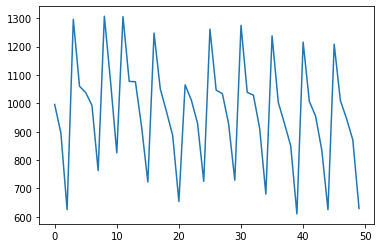

In [ ]:
submission_esb['중식계'].plot()

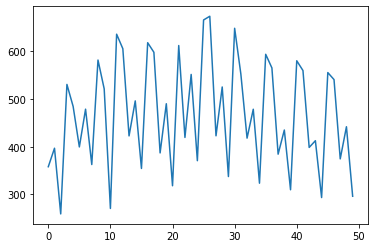

In [ ]:
submission_esb['석식계'].plot()